<a href="https://colab.research.google.com/github/nandini78487/VANAM_NANDINI/blob/main/IMAGE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
data_flag = 'pneumoniamnist'
download = True

NUM_EPOCHS = 5
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [ ]:
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


In [ ]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(val_dataset)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 624
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of

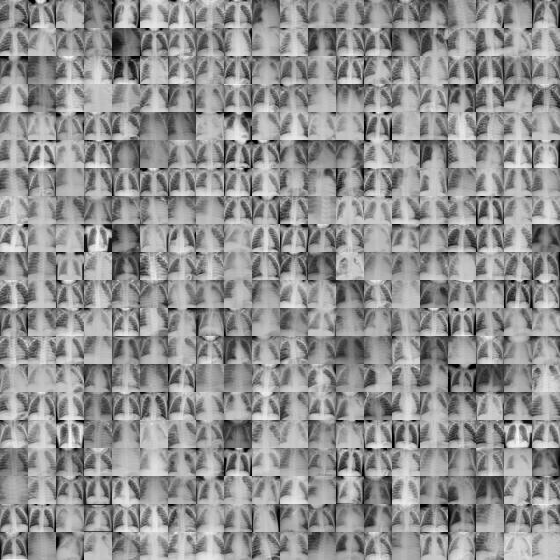

In [ ]:
train_dataset.montage(length=20)

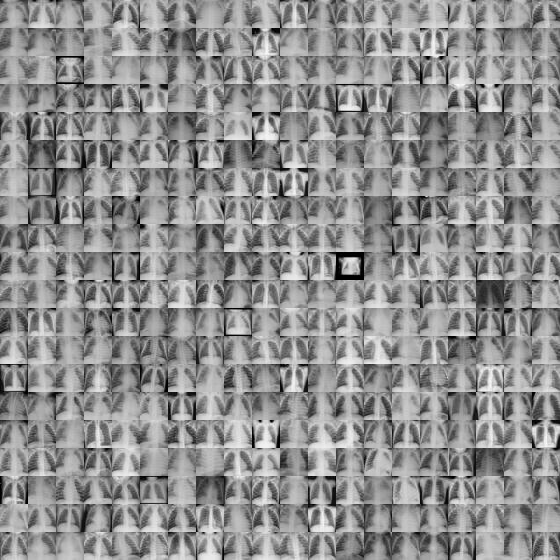

In [ ]:
test_dataset.montage(length=20)

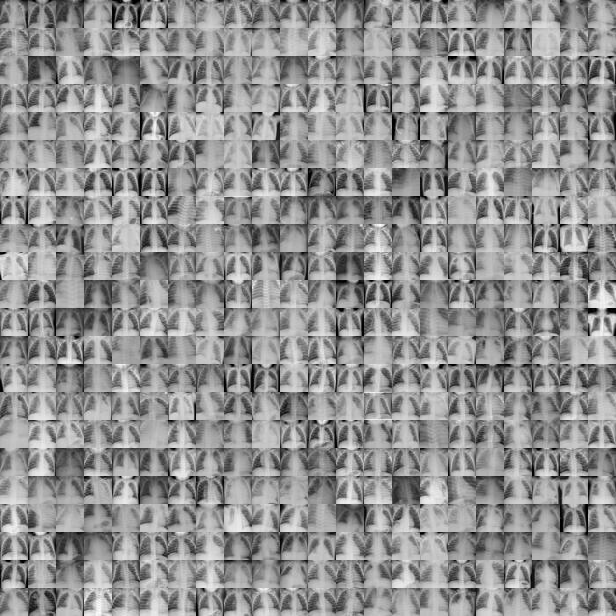

In [ ]:
val_dataset.montage(length=22)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
n_epochs=2
log_interval=10
learning_rate = 0.001
momentum = 0.5
batch_size_train = 6
batch_size_test = 1000

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
import torch
import torchvision

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-50-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.248612
Train Epoch: 1 [60/60000 (0%)]	Loss: 2.341558
Train Epoch: 1 [120/60000 (0%)]	Loss: 2.391462
Train Epoch: 1 [180/60000 (0%)]	Loss: 2.222239
Train Epoch: 1 [240/60000 (0%)]	Loss: 2.425446
Train Epoch: 1 [300/60000 (0%)]	Loss: 2.502058
Train Epoch: 1 [360/60000 (1%)]	Loss: 2.345575
Train Epoch: 1 [420/60000 (1%)]	Loss: 2.504709
Train Epoch: 1 [480/60000 (1%)]	Loss: 2.329657
Train Epoch: 1 [540/60000 (1%)]	Loss: 2.210287
Train Epoch: 1 [600/60000 (1%)]	Loss: 2.259980
Train Epoch: 1 [660/60000 (1%)]	Loss: 2.365118
Train Epoch: 1 [720/60000 (1%)]	Loss: 2.341640
Train Epoch: 1 [780/60000 (1%)]	Loss: 2.473469
Train Epoch: 1 [840/60000 (1%)]	Loss: 2.237648
Train Epoch: 1 [900/60000 (2%)]	Loss: 2.192743
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.348019
Train Epoch: 1 [1020/60000 (2%)]	Loss: 2.135879
Train Epoch: 1 [1080/60000 (2%)]	Loss: 2.389205
Train Epoch: 1 [1140/60000 (2%)]	Loss: 2.254063
Train Epoch: 1 [1200/60000 (2%)]	Loss: 2.218390
Train Epoch:

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-50-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.248612
Train Epoch: 1 [60/60000 (0%)]	Loss: 2.341558
Train Epoch: 1 [120/60000 (0%)]	Loss: 2.391462
Train Epoch: 1 [180/60000 (0%)]	Loss: 2.222239
Train Epoch: 1 [240/60000 (0%)]	Loss: 2.425446
Train Epoch: 1 [300/60000 (0%)]	Loss: 2.502058
Train Epoch: 1 [360/60000 (1%)]	Loss: 2.345575
Train Epoch: 1 [420/60000 (1%)]	Loss: 2.504709
Train Epoch: 1 [480/60000 (1%)]	Loss: 2.329657
Train Epoch: 1 [540/60000 (1%)]	Loss: 2.210287
Train Epoch: 1 [600/60000 (1%)]	Loss: 2.259980
Train Epoch: 1 [660/60000 (1%)]	Loss: 2.365118
Train Epoch: 1 [720/60000 (1%)]	Loss: 2.341640
Train Epoch: 1 [780/60000 (1%)]	Loss: 2.473469
Train Epoch: 1 [840/60000 (1%)]	Loss: 2.237648
Train Epoch: 1 [900/60000 (2%)]	Loss: 2.192743
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.348019
Train Epoch: 1 [1020/60000 (2%)]	Loss: 2.135879
Train Epoch: 1 [1080/60000 (2%)]	Loss: 2.389205
Train Epoch: 1 [1140/60000 (2%)]	Loss: 2.254063
Train Epoch: 1 [1200/60000 (2%)]	Loss: 2.218390
Train Epoch:

In [ ]:
import matplotlib.pyplot as plt

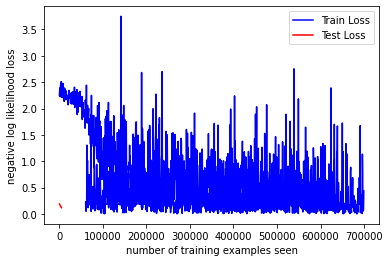

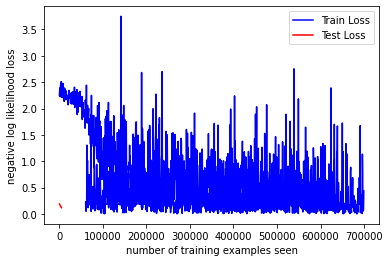

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [ ]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-50-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.392262
Train Epoch: 1 [60/60000 (0%)]	Loss: 2.508672
Train Epoch: 1 [120/60000 (0%)]	Loss: 2.345397
Train Epoch: 1 [180/60000 (0%)]	Loss: 2.321058
Train Epoch: 1 [240/60000 (0%)]	Loss: 2.307873
Train Epoch: 1 [300/60000 (0%)]	Loss: 2.242772
Train Epoch: 1 [360/60000 (1%)]	Loss: 2.247002
Train Epoch: 1 [420/60000 (1%)]	Loss: 2.126352
Train Epoch: 1 [480/60000 (1%)]	Loss: 2.149240
Train Epoch: 1 [540/60000 (1%)]	Loss: 2.122561
Train Epoch: 1 [600/60000 (1%)]	Loss: 2.046454
Train Epoch: 1 [660/60000 (1%)]	Loss: 1.680642
Train Epoch: 1 [720/60000 (1%)]	Loss: 1.196021
Train Epoch: 1 [780/60000 (1%)]	Loss: 2.220419
Train Epoch: 1 [840/60000 (1%)]	Loss: 1.541019
Train Epoch: 1 [900/60000 (2%)]	Loss: 1.407890
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.603540
Train Epoch: 1 [1020/60000 (2%)]	Loss: 1.622110
Train Epoch: 1 [1080/60000 (2%)]	Loss: 0.563601
Train Epoch: 1 [1140/60000 (2%)]	Loss: 0.891172
Train Epoch: 1 [1200/60000 (2%)]	Loss: 1.426277
Train Epoch:

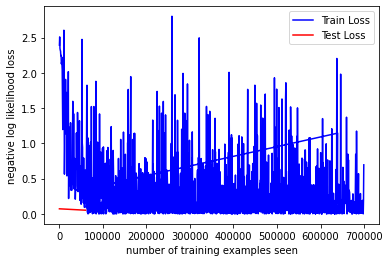

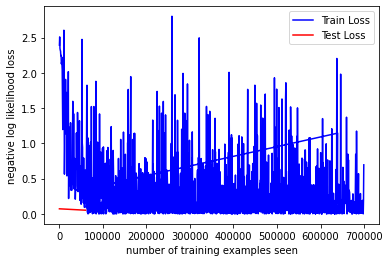

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig